In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [5]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0
        val_correct = 0
        train_total = 0
        val_total = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
            train_total += labels.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")
        print(f'Accuracy of the network on the 10000 test images: {100 * val_accuracy} %')

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10 - Training Loss: 1.2678 - Validation Loss: 1.1585
Accuracy of the network on the 10000 test images: 59.28 %
Epoch 2/10 - Training Loss: 1.2430 - Validation Loss: 1.0891
Accuracy of the network on the 10000 test images: 62.29 %
Epoch 3/10 - Training Loss: 1.2251 - Validation Loss: 1.1103
Accuracy of the network on the 10000 test images: 61.24000000000001 %
Epoch 4/10 - Training Loss: 1.2112 - Validation Loss: 1.0400
Accuracy of the network on the 10000 test images: 63.43 %
Epoch 5/10 - Training Loss: 1.1915 - Validation Loss: 1.0443
Accuracy of the network on the 10000 test images: 63.160000000000004 %
Epoch 6/10 - Training Loss: 1.1784 - Validation Loss: 1.0525
Accuracy of the network on the 10000 test images: 63.800000000000004 %
Epoch 7/10 - Training Loss: 1.1699 - Validation Loss: 1.0301
Accuracy of the network on the 10000 test images: 63.959999999999994 %
Epoch 8/10 - Training Loss: 1.1667 - Validation Loss: 1.0031
Accuracy of the network on the 10000 test images: 65.95

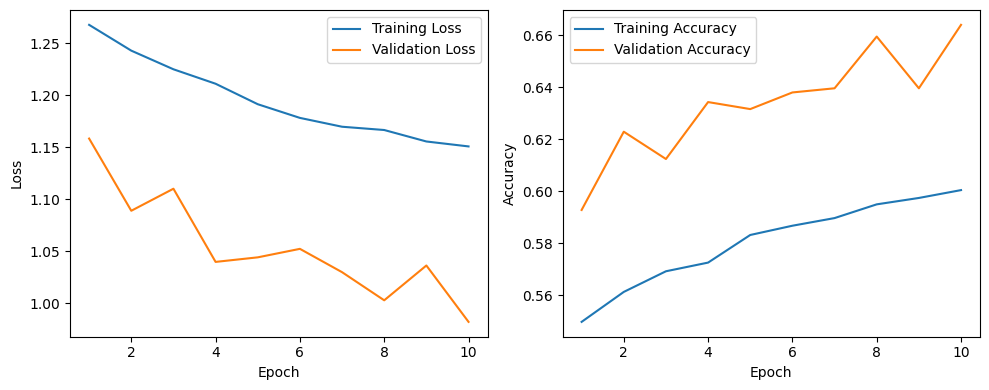

In [20]:
train(model,trainloader,testloader, criterion, optimizer,10)


In [21]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [22]:
%load_ext tensorboard


In [24]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [28]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

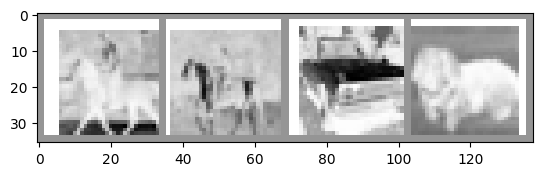

In [29]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images

matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)